## This project is a classification project, where we will be classifying customers based on their data if a loan can be approved for them.

## Here the false negative rate should be very low.As the customers wrongly classified as low risk could be bad for business.

* Since we have an imbalanced dataset, we will be using data balancing techniques such as oversampling, undersampling , SMOTE etc.
* We have 20 input variables, where we have 7 numerical  and 13 are categorical.
* We will be adding penalties for mis classifications. Where the False Negatives will be charged 5 whereas the cost of False Positive would be 1.
* Since we also have categorical values, we will be using one-hot encoding.
* The numerical variables have a different scale, so scaling would be required for the algorithms which are sensitive to scale.
* In the last column we have the classifications for positive and negative classes as 1 and 2, we will convert them to 0 and 1.
* In scenarios where False negatives are more dangerous, we want higher recall scores.Recall is the percentage of the total correct percentage of the releavent results classified by the algorithms.

In [1]:
from pandas import read_csv

In [2]:
filename = 'german.csv'
dataframe = read_csv(filename,header=None)

In [3]:
dataframe.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
dataframe.describe()

,1,4,7,10,12,15,17,20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [5]:
print(dataframe.shape)

(1000, 21)


In [6]:
from collections import Counter
target=dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v/len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k,v,per))   

Class=1, Count=700, Percentage=70.000%
Class=2, Count=300, Percentage=30.000%


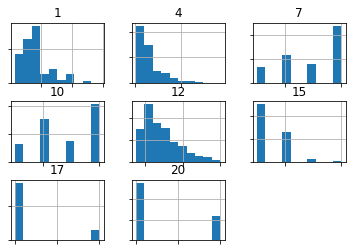

In [7]:
# Now, we will create a histogram for all the numeric variables.
from matplotlib import pyplot
%matplotlib inline
num_ix = dataframe.select_dtypes(include=['int64','float64']).columns
subset=dataframe[num_ix]
ax=subset.hist()
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

### As we can see that most of the variables have different distributions such as gaussian, exponential etc.
### For better results we will scale the data.
### Now we will split the data into input and output variables.

In [8]:
last_ix =len(dataframe.columns)-1

X,y = dataframe.drop(last_ix,axis=1),dataframe[last_ix]

In [9]:
# Now we will do one-hot-encoding on the categorical variables  columns.
# selectin the categorical values.
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cat_ix = X.select_dtypes(include=['object','bool']).columns
ct = ColumnTransformer([('o',OneHotEncoder(),cat_ix)],remainder='passthrough')
X = ct.fit_transform(X)

In [10]:
from sklearn.preprocessing import LabelEncoder
y =LabelEncoder().fit_transform(y)
return X,y
## Why did we not use one-got encoder here?

SyntaxError: 'return' outside function (<ipython-input-10-d4457237a42f>, line 3)

##### Now we will be creating a function where we will define the F2 metric so that we can define the metric to evaluate the predictions.


In [11]:
def f2_measure(y_true,y_pred):
    return fbeta_score(y_true,y_pred,beta=2)

In [12]:
# We create a function where we evaluate a given model on the given folds and analyze the performance of the folds on the basis of F2 measures.
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
def evaluate_model(X,y,model):
    cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    metric=make_scorer(f2_measure)
    scores=cross_val_score(model,X,y,scoring=metric,cv=cv,n_jobs=-1)
    return scores

In [13]:
## We will use the the above test harness for baseline predictions.
## The model which will predict the minority class for the examples will have a high recall score.
from sklearn.dummy import DummyClassifier
model=DummyClassifier(strategy='constant',constant=1)

In [14]:
from numpy import mean
from numpy import std
scores=evaluate_model(X,y,model)
print('Mean F2: %.3f (%.3f)' % (mean(scores),std(scores)))

Mean F2: 0.682 (0.000)


In [15]:
## We have a test harness and a baseline for performance so now we can spot check the algorithms that can help us further our cause.
## We will be using the algorithms with the default parameters, not the tuned ones.
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
def get_models():
    models,names=list(),list()
    models.append(LogisticRegression(solver='liblinear'))
    names.append("LR")
    models.append(LinearDiscriminantAnalysis())
    names.append("LDA")
    models.append(GaussianNB())
    names.append("NB")
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models,names

#### We will evaluate each model separately and store the scores to be evaluated later.
#### But first we will be transforming the data, the categorical input variables will be one -hot encoded and the numerical values will be scaled using the min-max scaler on every cross-validation set.
#### We will be using the pipeline for transforming the data  and updating the theloaddataset function for updating the numerical input variables as well. 

In [16]:
def load_dataset(filename):
    dataframe = read_csv(filename,header=None)
    last_ix = len(dataframe.columns)-1
    X,y = dataframe.drop(last_ix,axis=1),dataframe[last_ix]
    cat_ix=X.select_dtypes(include=['object','bool']).columns
    num_ix = X.select_dtypes(include=['int64','float64']).columns
    y = LabelEncoder().fit_transform(y)
    return X.values, y, cat_ix, num_ix

In [17]:
X,y,cat_ix,num_ix = load_dataset(filename)
models,names = get_models()
results = list()

In [18]:
for i in range(len(models)):
    ct=ColumnTransformer([('c',OneHotEncoder(),cat_ix),('n',MinMaxScaler(),num_ix)])
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    scores = evaluate_model(X,y,pipeline)
    results.append(scores)

#### Now we compare the algorithms using the F2 measure.

In [19]:
# Now we will be directly comparing the means of the F2 scores for the algorithms.
print('>%s %.3f (%.3f)' % (names[i],mean(scores),std(scores)))

>SVM 0.436 (0.077)


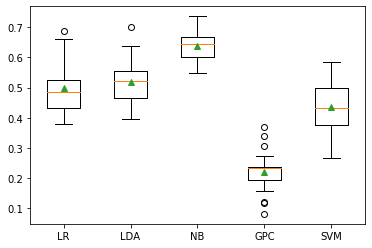

In [20]:
from matplotlib import pyplot
%matplotlib inline
pyplot.boxplot(results,labels=names,showmeans=True)
pyplot.show()

### As we already knew that the dataset we are dealing with here are a case of imbalanced dataset. We will be using undersampling techniques for solving this issue.
### Undersampling methods are rarely used for addressing imbalanced data. Undersampling helps remove those data instances which may increase the accuracy of a classification algorithm.

#### For the undersampling experiment we will be using the following undersampling techniques.
* Tomek Links
* Edited Nearest Neighbors
* Repeated Edited Nearest Neighbors
* One sided Selection
* Neighborhood Cleaning Rule

* The TOMEK and ENN methods can be used for selecting which instances of the dataset need to be deleted.
* The OSS and NCR models can be used for selecting the examples which both need to be kept and deleted.
* We will check all the undersampling algorithms with the logistic regression algorithm.
 
 
* We will update the get model function accordingly so that the undersampling methods can be called.

In [30]:
## We will edit the get_models.
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
def get_models():
    models,names = list(),list()
    models.append(TomekLinks())
    names.append('TL')
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    models.append(OneSidedSelection())
    names.append('OSS')
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    return models, names
X, y, cat_ix, num_ix = load_dataset(filename)
models,names = get_models()
results = list()

### Since we are using undersampling methods we cannot use the scikit learn pipeline for analyzing our undersampling methods.
### We will be using the pipeline provided by the  imblearn library.
### The first step would be to one hot encode the categorical variables and normalization of the numerical variables, then we will use the undersampling techniques and then we will fit the model.


In [31]:
# Creating the results for the undersampling models.
for i in range (len(models)):
    model =LogisticRegression(solver='liblinear',class_weight='balanced')
    ct=ColumnTransformer([('c',OneHotEncoder(),cat_ix),('n',MinMaxScaler(),num_ix)])
    pipeline = Pipeline(steps=[('t',ct),('s',models[i]),('m',model)])
    scores = evaluate_model(X,y,pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i],mean(scores),std(scores)))

>TL 0.669 (0.057)
>ENN 0.706 (0.048)
>RENN 0.714 (0.041)
>OSS 0.669 (0.057)
>NCR 0.693 (0.052)


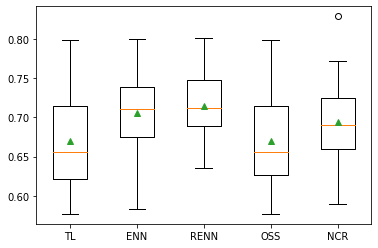

In [33]:
# Evaluating the performances of the visually.
pyplot.boxplot(results,labels=names,showmeans=True)
pyplot.show()

#### As we can see that the overall performance of the model was boosted.
#### We will use the RENN model as it was the highest performing model.
#### We will fit the complete data to the model


In [34]:
pipeline.fit(X,y)

C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(m

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c', OneHotEncoder(),
                                                  Int64Index([0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19], dtype='int64')),
                                                 ('n', MinMaxScaler(),
                                                  Int64Index([1, 4, 7, 10, 12, 15, 17], dtype='int64'))])),
                ('s', NeighbourhoodCleaningRule()),
                ('m',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

## Once the model has been fitted, we can make predictions for the new data by calling the predict() function.